# Multiple Imputation using MICE

**Date:** 9 October 2025

**Topic:** Multiple Imputation by Chained Equations for missing data handling

This notebook covers:
1. Introduction to MICE Algorithm
2. Titanic Dataset Imputation
3. Life Expectancy Dataset Analysis
4. Planets Dataset Application
5. Comparative Analysis and Validation
6. Best Practices and Limitations

## 1. Setup and Dependencies

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")

## 2. Introduction to MICE Algorithm

### 2.1 MICE Methodology Overview

In [2]:
print("MULTIPLE IMPUTATION BY CHAINED EQUATIONS (MICE)")
print("=" * 55)
print("\nAlgorithm Steps:")
print("1. Replace missing values with initial estimates (mean/mode)")
print("2. For each variable with missing data:")
print("   a. Set current estimates to missing")
print("   b. Regress variable on other variables")
print("   c. Predict missing values using regression")
print("   d. Update estimates with new predictions")
print("3. Repeat step 2 for specified iterations")
print("4. Output imputed dataset")

print("\nKey Advantages:")
print("- Accounts for uncertainty in imputations")
print("- Preserves relationships between variables")
print("- Flexible for different variable types")
print("- Better than single imputation methods")

print("\nLimitations:")
print("- Assumes data is Missing at Random (MAR)")
print("- Computationally intensive")
print("- Requires careful model specification")
print("- May not work well with high missingness rates")

MULTIPLE IMPUTATION BY CHAINED EQUATIONS (MICE)

Algorithm Steps:
1. Replace missing values with initial estimates (mean/mode)
2. For each variable with missing data:
   a. Set current estimates to missing
   b. Regress variable on other variables
   c. Predict missing values using regression
   d. Update estimates with new predictions
3. Repeat step 2 for specified iterations
4. Output imputed dataset

Key Advantages:
- Accounts for uncertainty in imputations
- Preserves relationships between variables
- Flexible for different variable types
- Better than single imputation methods

Limitations:
- Assumes data is Missing at Random (MAR)
- Computationally intensive
- Requires careful model specification
- May not work well with high missingness rates


## 3. Titanic Dataset Analysis

### 3.1 Data Loading and Exploration

In [3]:
# Load Titanic dataset
titanic = sns.load_dataset('titanic')

print("Titanic Dataset Information:")
print(f"Shape: {titanic.shape}")
print(f"\nColumns: {list(titanic.columns)}")
print("\nFirst few rows:")
display(titanic.head())

# Analyze missing values
print("\nMissing Values Analysis:")
missing_counts = titanic.isnull().sum()
missing_percentages = (missing_counts / len(titanic)) * 100

missing_summary = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percentage': missing_percentages.values
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

print(missing_summary)

# Total missingness
total_missing = missing_counts.sum()
total_cells = titanic.shape[0] * titanic.shape[1]
print(f"\nTotal missing values: {total_missing}")
print(f"Overall missingness rate: {(total_missing/total_cells)*100:.2f}%")

Titanic Dataset Information:
Shape: (891, 15)

Columns: ['survived', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone']

First few rows:


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True



Missing Values Analysis:
         Column  Missing_Count  Missing_Percentage
11         deck            688           77.216611
3           age            177           19.865320
7      embarked              2            0.224467
12  embark_town              2            0.224467

Total missing values: 869
Overall missingness rate: 6.50%


### 3.2 Data Preprocessing for MICE

In [4]:
# Select relevant columns and prepare for imputation
# Focus on numeric and easily encodable variables
titanic_subset = titanic[['age', 'fare', 'pclass', 'sex', 'survived']].copy()

# Encode categorical variables
titanic_encoded = pd.get_dummies(titanic_subset, columns=['sex'], drop_first=True)

print("Preprocessed Titanic Dataset:")
print(f"Shape: {titanic_encoded.shape}")
print(f"Columns: {list(titanic_encoded.columns)}")
display(titanic_encoded.head())

# Check missing values in subset
print("\nMissing values in subset:")
subset_missing = titanic_encoded.isnull().sum()
print(subset_missing[subset_missing > 0])

# Display some rows with missing age values
print("\nSample rows with missing age:")
missing_age_sample = titanic_encoded[titanic_encoded['age'].isnull()].head(10)
display(missing_age_sample)

Preprocessed Titanic Dataset:
Shape: (891, 5)
Columns: ['age', 'fare', 'pclass', 'survived', 'sex_male']


,age,fare,pclass,survived,sex_male
0,22.0,7.2500,3,0,True
1,38.0,71.2833,1,1,False
2,26.0,7.9250,3,1,False
3,35.0,53.1000,1,1,False
4,35.0,8.0500,3,0,True



Missing values in subset:
age    177
dtype: int64

Sample rows with missing age:


,age,fare,pclass,survived,sex_male
5,NaN,8.4583,3,0,True
17,NaN,13.0000,2,1,True
19,NaN,7.2250,3,1,False
26,NaN,7.2250,3,0,True
28,NaN,7.8792,3,1,False
29,NaN,7.8958,3,0,True
31,NaN,146.5208,1,1,False
32,NaN,7.7500,3,1,False
36,NaN,7.2292,3,1,True
42,NaN,7.8958,3,0,True


### 3.3 MICE Imputation on Titanic Dataset

In [5]:
# Apply MICE imputation
mice_imputer = IterativeImputer(
    max_iter=10,
    random_state=42,
    estimator=LinearRegression()
)

# Fit and transform the data
titanic_imputed_array = mice_imputer.fit_transform(titanic_encoded)
titanic_imputed = pd.DataFrame(
    titanic_imputed_array, 
    columns=titanic_encoded.columns
)

print("MICE Imputation Results - Titanic:")
print("=" * 40)

# Verify no missing values remain
remaining_missing = titanic_imputed.isnull().sum()
print(f"Remaining missing values: {remaining_missing.sum()}")

# Compare original and imputed data
print("\nComparison - Original vs Imputed Data:")
comparison_data = pd.DataFrame({
    'Original_Age_Mean': titanic_encoded['age'].mean(),
    'Imputed_Age_Mean': titanic_imputed['age'].mean(),
    'Original_Age_Std': titanic_encoded['age'].std(),
    'Imputed_Age_Std': titanic_imputed['age'].std()
}, index=[0])

display(comparison_data.round(3))

# Display sample of imputed values
print("\nSample of imputed age values:")
original_missing_mask = titanic_encoded['age'].isnull()
imputed_values = titanic_imputed.loc[original_missing_mask, 'age'].head(10)
print(imputed_values.round(2).tolist())

MICE Imputation Results - Titanic:
Remaining missing values: 0

Comparison - Original vs Imputed Data:


,Original_Age_Mean,Imputed_Age_Mean,Original_Age_Std,Imputed_Age_Std
0,29.699,29.29,14.526,13.367



Sample of imputed age values:
[26.66, 29.34, 19.36, 26.7, 19.34, 26.68, 32.5, 19.35, 20.48, 26.68]


### 3.4 Titanic Imputation Visualization

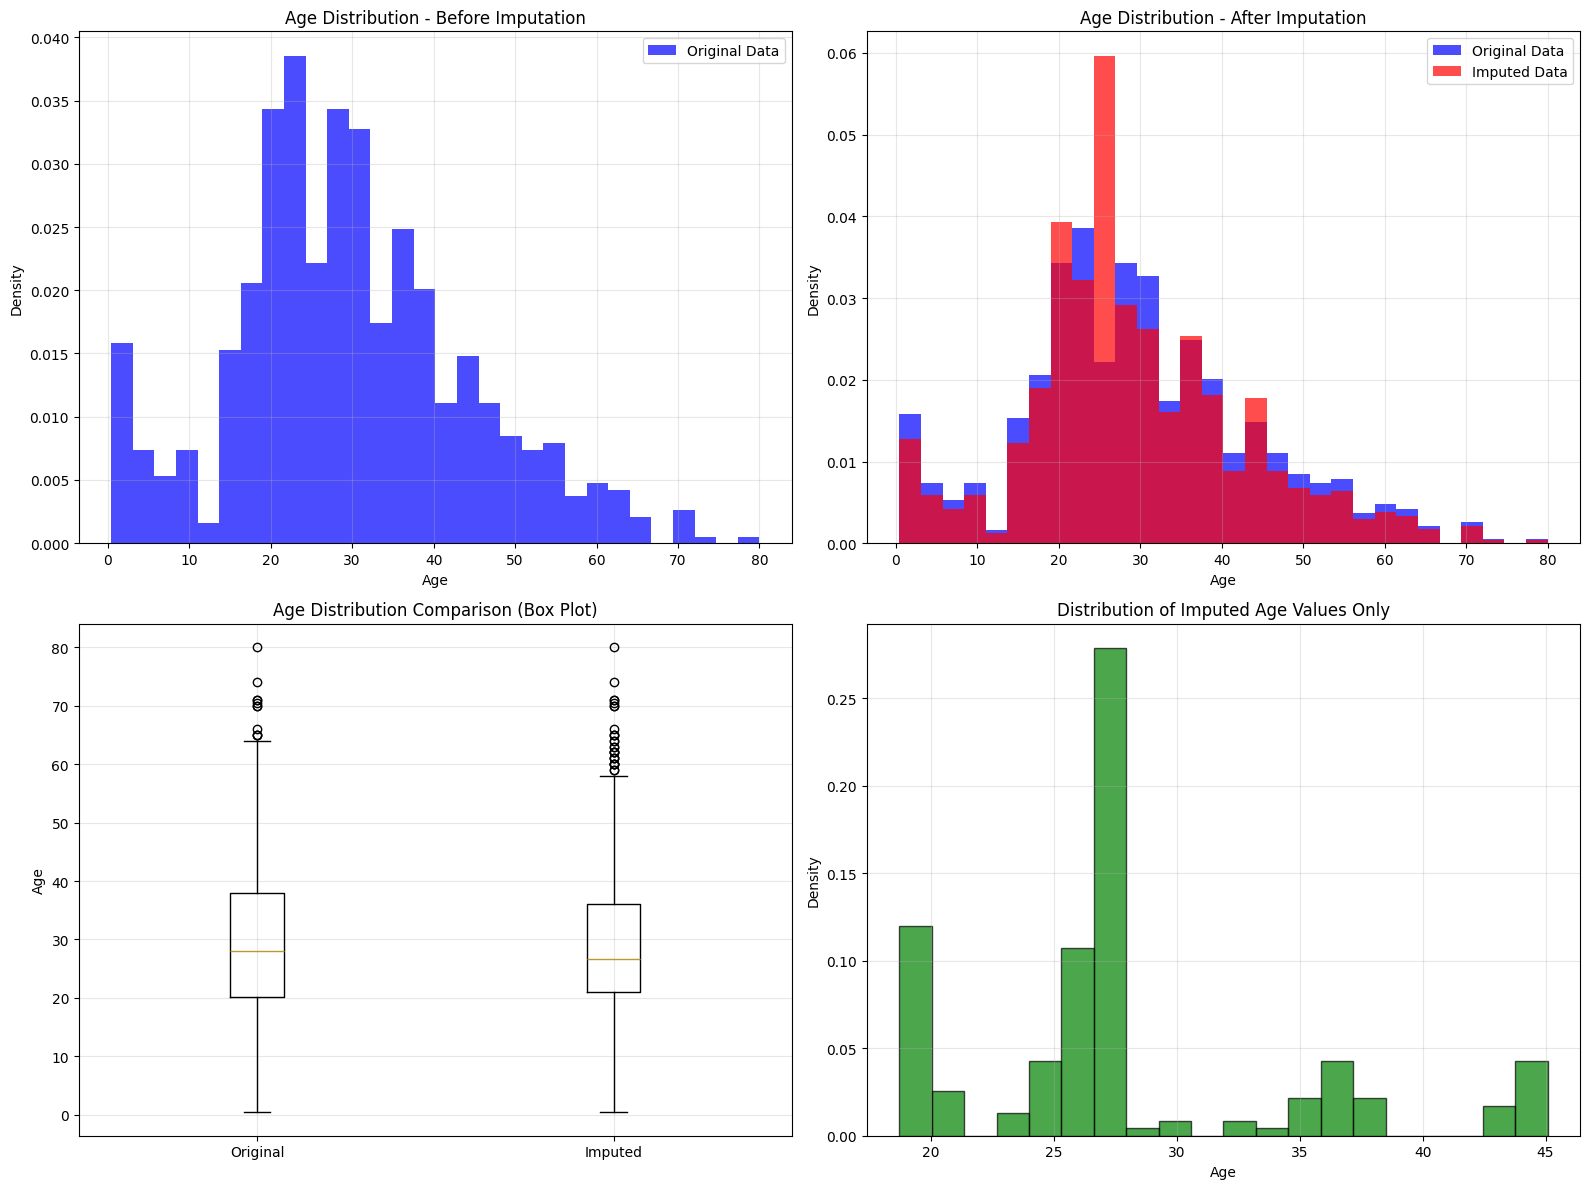

Statistical Comparison:
Original age statistics (excluding missing):
  Mean: 29.70
  Median: 28.00
  Std: 14.53

Imputed dataset age statistics:
  Mean: 29.29
  Median: 26.70
  Std: 13.37

Imputed values only statistics:
  Mean: 27.64
  Median: 26.68
  Std: 6.73


In [6]:
# Create comprehensive visualization for Titanic imputation
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Age distribution before imputation
ax1.hist(titanic_encoded['age'].dropna(), bins=30, alpha=0.7, color='blue', 
         density=True, label='Original Data')
ax1.set_xlabel('Age')
ax1.set_ylabel('Density')
ax1.set_title('Age Distribution - Before Imputation')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Age distribution after imputation
ax2.hist(titanic_encoded['age'].dropna(), bins=30, alpha=0.7, color='blue', 
         density=True, label='Original Data')
ax2.hist(titanic_imputed['age'], bins=30, alpha=0.7, color='red', 
         density=True, label='Imputed Data')
ax2.set_xlabel('Age')
ax2.set_ylabel('Density')
ax2.set_title('Age Distribution - After Imputation')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Box plots comparison
age_data = [
    titanic_encoded['age'].dropna(),
    titanic_imputed['age']
]
ax3.boxplot(age_data, labels=['Original', 'Imputed'])
ax3.set_ylabel('Age')
ax3.set_title('Age Distribution Comparison (Box Plot)')
ax3.grid(True, alpha=0.3)

# Plot 4: Imputed values only
imputed_ages = titanic_imputed.loc[original_missing_mask, 'age']
ax4.hist(imputed_ages, bins=20, alpha=0.7, color='green', 
         edgecolor='black', density=True)
ax4.set_xlabel('Age')
ax4.set_ylabel('Density')
ax4.set_title('Distribution of Imputed Age Values Only')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
print("Statistical Comparison:")
print(f"Original age statistics (excluding missing):")
print(f"  Mean: {titanic_encoded['age'].mean():.2f}")
print(f"  Median: {titanic_encoded['age'].median():.2f}")
print(f"  Std: {titanic_encoded['age'].std():.2f}")

print(f"\nImputed dataset age statistics:")
print(f"  Mean: {titanic_imputed['age'].mean():.2f}")
print(f"  Median: {titanic_imputed['age'].median():.2f}")
print(f"  Std: {titanic_imputed['age'].std():.2f}")

print(f"\nImputed values only statistics:")
print(f"  Mean: {imputed_ages.mean():.2f}")
print(f"  Median: {imputed_ages.median():.2f}")
print(f"  Std: {imputed_ages.std():.2f}")

## 4. Life Expectancy Dataset Analysis

### 4.1 Dataset Loading and Exploration

In [7]:
# Create synthetic life expectancy dataset for demonstration
# In real scenarios, you would load from the actual WHO dataset
np.random.seed(42)
n_countries = 500
n_years = 5
total_rows = n_countries * n_years

# Generate synthetic life expectancy data
life_expectancy_data = {
    'Country': np.repeat([f'Country_{i}' for i in range(n_countries)], n_years),
    'Year': np.tile(range(2015, 2020), n_countries),
    'Life_expectancy': np.random.normal(70, 10, total_rows),
    'Adult_Mortality': np.random.exponential(150, total_rows),
    'Alcohol': np.random.exponential(5, total_rows),
    'Hepatitis_B': np.random.normal(85, 15, total_rows),
    'GDP': np.random.exponential(10000, total_rows),
    'Schooling': np.random.normal(12, 3, total_rows)
}

# Create DataFrame
life_expectancy_df = pd.DataFrame(life_expectancy_data)

# Introduce missing values randomly
missing_rate = 0.15
numeric_cols = ['Life_expectancy', 'Adult_Mortality', 'Alcohol', 'Hepatitis_B', 'GDP', 'Schooling']

for col in numeric_cols[1:]:  # Don't make target variable missing
    n_missing = int(len(life_expectancy_df) * missing_rate * np.random.uniform(0.5, 1.5))
    missing_indices = np.random.choice(len(life_expectancy_df), n_missing, replace=False)
    life_expectancy_df.loc[missing_indices, col] = np.nan

print("Synthetic Life Expectancy Dataset:")
print(f"Shape: {life_expectancy_df.shape}")
print(f"\nFirst few rows:")
display(life_expectancy_df.head(10))

# Analyze missing patterns
print("\nMissing Values Analysis:")
missing_analysis = life_expectancy_df.isnull().sum()
missing_percentages = (missing_analysis / len(life_expectancy_df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_analysis.index,
    'Missing_Count': missing_analysis.values,
    'Missing_Percentage': missing_percentages.values
})
display(missing_df[missing_df['Missing_Count'] > 0])

Synthetic Life Expectancy Dataset:
Shape: (2500, 8)

First few rows:


,Country,Year,Life_expectancy,Adult_Mortality,Alcohol,Hepatitis_B,GDP,Schooling
0,Country_0,2015,74.967142,NaN,6.227798,73.509322,NaN,NaN
1,Country_0,2016,68.617357,173.341367,0.967258,78.080994,NaN,10.418802
2,Country_0,2017,76.476885,17.552876,1.341903,51.208099,NaN,8.929021
3,Country_0,2018,85.230299,51.201978,3.409759,90.039523,1511.543549,11.142940
4,Country_0,2019,67.658466,55.617574,NaN,80.907332,21765.174707,16.875991
5,Country_1,2015,67.658630,43.143700,1.189474,99.552626,13084.915904,7.914975
6,Country_1,2016,85.792128,108.542709,0.778827,68.523862,1799.287369,17.076939
7,Country_1,2017,77.674347,115.036437,7.114311,75.713156,8342.914615,11.220836
8,Country_1,2018,65.305256,66.214986,3.471935,62.402121,3749.208416,NaN
9,Country_1,2019,75.425600,65.494417,12.139898,69.935642,NaN,NaN



Missing Values Analysis:


,Column,Missing_Count,Missing_Percentage
3,Adult_Mortality,522,20.88
4,Alcohol,199,7.96
5,Hepatitis_B,484,19.36
6,GDP,540,21.60
7,Schooling,415,16.60


### 4.2 Life Expectancy MICE Imputation

In [8]:
# Prepare data for imputation (numeric columns only)
life_expectancy_numeric = life_expectancy_df[numeric_cols].copy()

print("Pre-imputation summary:")
print(life_expectancy_numeric.describe())

# Apply MICE imputation with Random Forest estimator for better performance
mice_imputer_life = IterativeImputer(
    max_iter=20,
    random_state=42,
    estimator=RandomForestRegressor(n_estimators=10, random_state=42)
)

# Fit and transform
life_expectancy_imputed_array = mice_imputer_life.fit_transform(life_expectancy_numeric)
life_expectancy_imputed = pd.DataFrame(
    life_expectancy_imputed_array,
    columns=numeric_cols
)

# Add back non-numeric columns
life_expectancy_imputed['Country'] = life_expectancy_df['Country']
life_expectancy_imputed['Year'] = life_expectancy_df['Year']

print("\nPost-imputation verification:")
print(f"Remaining missing values: {life_expectancy_imputed.isnull().sum().sum()}")

print("\nPost-imputation summary:")
print(life_expectancy_imputed[numeric_cols].describe())

Pre-imputation summary:
       Life_expectancy  Adult_Mortality      Alcohol  Hepatitis_B  \
count      2500.000000      1978.000000  2301.000000  2016.000000   
mean         70.337640       147.144145     4.857978    84.742563   
std           9.828249       147.990196     4.882092    15.481116   
min          37.587327         0.004608     0.001205    27.450167   
25%          63.724589        42.146357     1.392783    74.144641   
50%          70.264884       100.282795     3.331602    84.412704   
75%          76.797523       202.863206     6.702697    95.243001   
max         108.527315      1158.529428    37.626017   137.935828   

                GDP    Schooling  
count   1960.000000  2085.000000  
mean   10041.687997    12.021495  
std    10412.479711     2.991130  
min        1.577570     1.873263  
25%     2719.682362    10.082804  
50%     6488.175112    11.995456  
75%    14009.364510    13.953993  
max    73159.082428    22.286731  

Post-imputation verification:
Remainin

### 4.3 Life Expectancy Imputation Validation

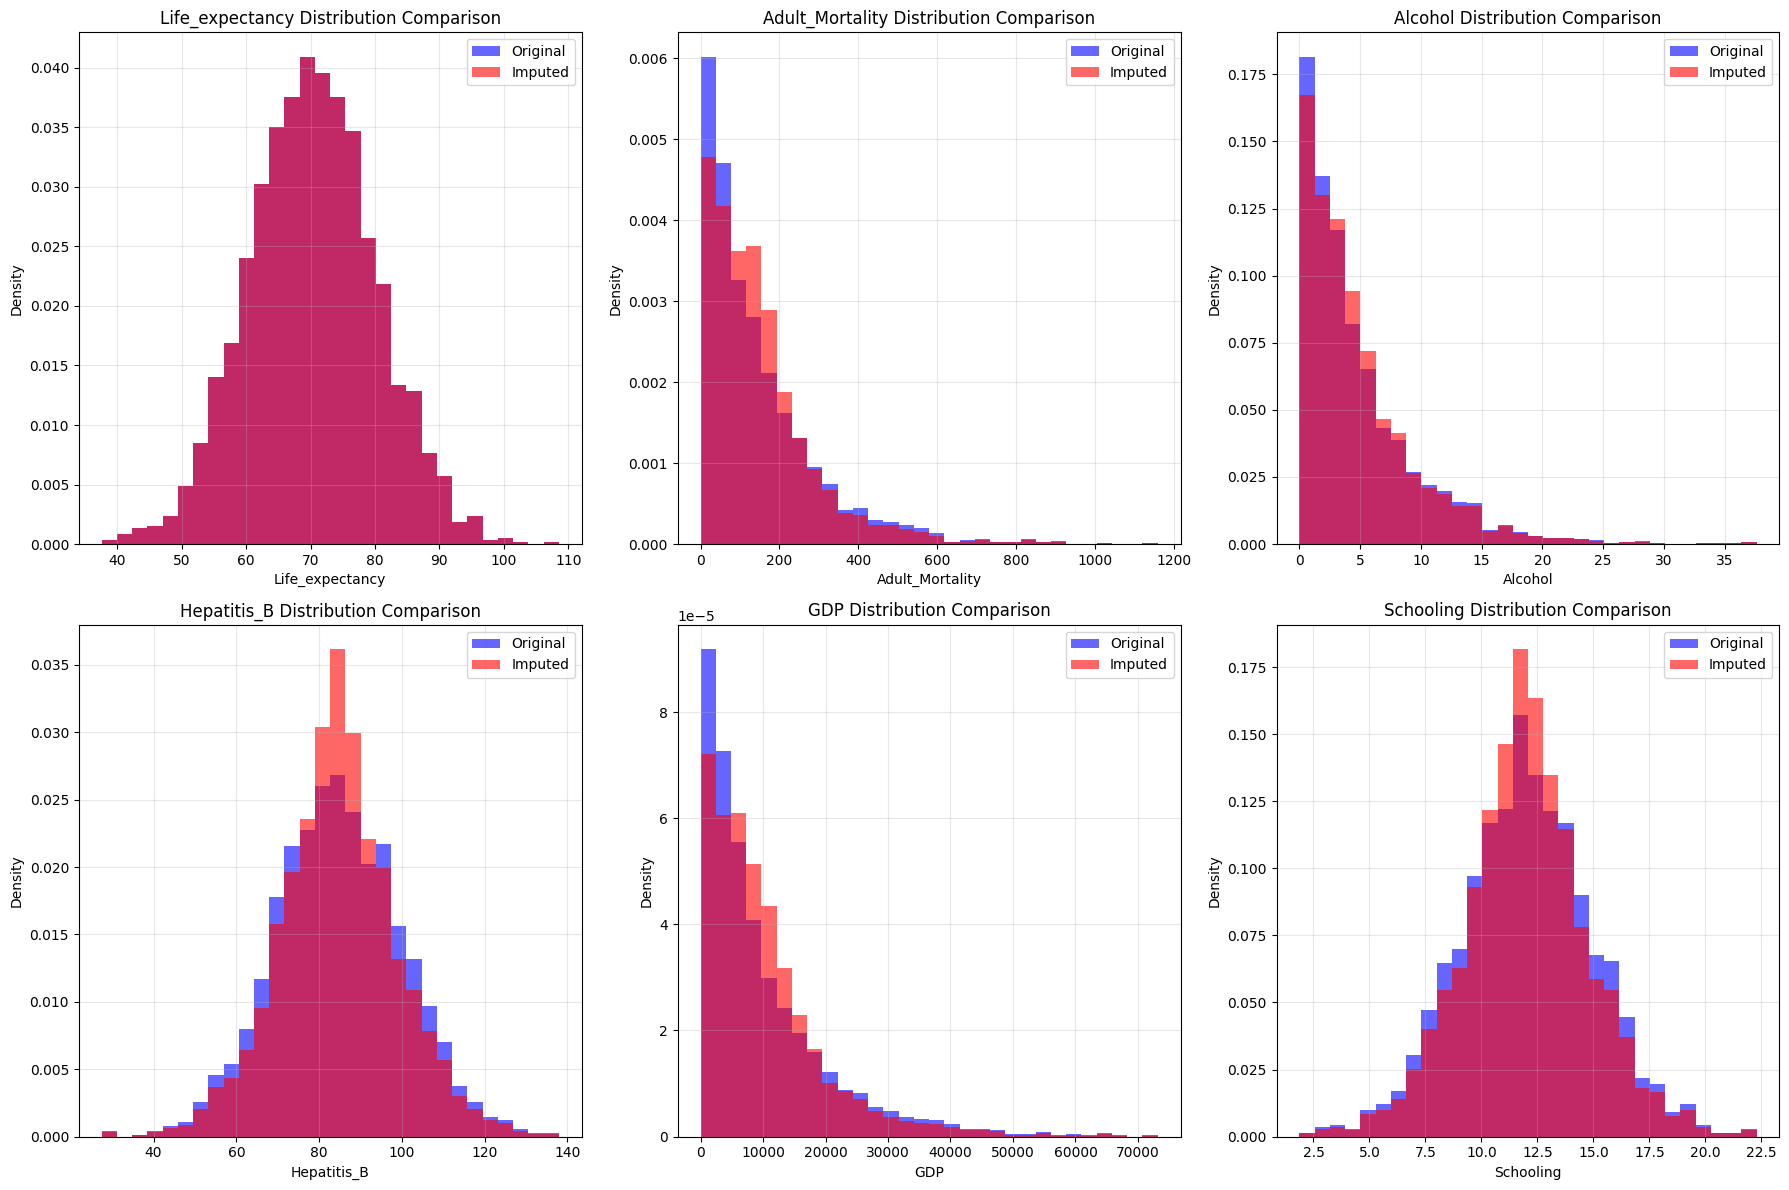


Statistical Comparison - Life Expectancy Dataset:


,Variable,Original_Mean,Imputed_Mean,Original_Std,Imputed_Std,Mean_Diff,Std_Diff
0,Life_expectancy,70.338,70.338,9.828,9.828,0.000,0.000
1,Adult_Mortality,147.144,148.836,147.990,135.043,1.692,12.947
2,Alcohol,4.858,4.877,4.882,4.719,0.019,0.163
3,Hepatitis_B,84.743,84.706,15.481,14.155,0.036,1.326
4,GDP,10041.688,10188.866,10412.480,9442.961,147.178,969.518
5,Schooling,12.021,11.993,2.991,2.777,0.029,0.214


In [9]:
# Compare distributions before and after imputation
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    
    # Original data (non-missing)
    original_data = life_expectancy_numeric[col].dropna()
    ax.hist(original_data, bins=30, alpha=0.6, color='blue', 
            density=True, label='Original')
    
    # Imputed complete dataset
    ax.hist(life_expectancy_imputed[col], bins=30, alpha=0.6, color='red', 
            density=True, label='Imputed')
    
    ax.set_title(f'{col} Distribution Comparison')
    ax.set_xlabel(col)
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison table
comparison_stats = []
for col in numeric_cols:
    original = life_expectancy_numeric[col].dropna()
    imputed = life_expectancy_imputed[col]
    
    comparison_stats.append({
        'Variable': col,
        'Original_Mean': original.mean(),
        'Imputed_Mean': imputed.mean(),
        'Original_Std': original.std(),
        'Imputed_Std': imputed.std(),
        'Mean_Diff': abs(original.mean() - imputed.mean()),
        'Std_Diff': abs(original.std() - imputed.std())
    })

comparison_df = pd.DataFrame(comparison_stats)
print("\nStatistical Comparison - Life Expectancy Dataset:")
display(comparison_df.round(3))

## 5. Planets Dataset Application

### 5.1 Planets Dataset Analysis

In [10]:
# Load planets dataset
planets_df = sns.load_dataset("planets")

print("Planets Dataset Information:")
print(f"Shape: {planets_df.shape}")
print(f"\nColumns: {list(planets_df.columns)}")
display(planets_df.head())

# Check missing values
print("\nMissing Values in Planets Dataset:")
planets_missing = planets_df.isnull().sum()
planets_missing_df = pd.DataFrame({
    'Column': planets_missing.index,
    'Missing_Count': planets_missing.values,
    'Missing_Percentage': (planets_missing.values / len(planets_df)) * 100
})
display(planets_missing_df[planets_missing_df['Missing_Count'] > 0])

# Focus on numeric variables with missing values
numeric_planets = planets_df[['orbital_period', 'mass', 'distance']].copy()
print("\nNumeric subset for imputation:")
print(f"Shape: {numeric_planets.shape}")
display(numeric_planets.head(10))

# Show some missing patterns
print("\nRows with missing values (sample):")
missing_rows = numeric_planets[numeric_planets.isnull().any(axis=1)]
display(missing_rows.head(10))

Planets Dataset Information:
Shape: (1035, 6)

Columns: ['method', 'number', 'orbital_period', 'mass', 'distance', 'year']


,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009



Missing Values in Planets Dataset:


,Column,Missing_Count,Missing_Percentage
2,orbital_period,43,4.154589
3,mass,522,50.434783
4,distance,227,21.932367



Numeric subset for imputation:
Shape: (1035, 3)


,orbital_period,mass,distance
0,269.300,7.10,77.40
1,874.774,2.21,56.95
2,763.000,2.60,19.84
3,326.030,19.40,110.62
4,516.220,10.50,119.47
5,185.840,4.80,76.39
6,1773.400,4.64,18.15
7,798.500,NaN,21.41
8,993.300,10.30,73.10
9,452.800,1.99,74.79



Rows with missing values (sample):


,orbital_period,mass,distance
7,798.50000,NaN,21.41
20,0.73654,NaN,12.53
25,116.68840,NaN,18.11
26,691.90000,NaN,81.50
29,NaN,NaN,45.52
30,NaN,NaN,165.00
31,NaN,NaN,140.00
32,10220.00000,6.05,NaN
33,NaN,NaN,NaN
34,NaN,NaN,145.00


### 5.2 Planets MICE Imputation

In [11]:
# Apply MICE to planets dataset
mice_imputer_planets = IterativeImputer(
    max_iter=15,
    random_state=42,
    estimator=RandomForestRegressor(n_estimators=20, random_state=42)
)

# Transform the data
planets_imputed_array = mice_imputer_planets.fit_transform(numeric_planets)
planets_imputed = pd.DataFrame(
    planets_imputed_array,
    columns=numeric_planets.columns
)

print("Planets MICE Imputation Results:")
print("=" * 40)

# Verification
print(f"Original missing values: {numeric_planets.isnull().sum().sum()}")
print(f"Remaining missing values: {planets_imputed.isnull().sum().sum()}")

# Compare before and after statistics
print("\nBefore Imputation:")
display(numeric_planets.describe())

print("\nAfter Imputation:")
display(planets_imputed.describe())

# Show examples of imputed values
print("\nExample imputed values:")
mass_missing_mask = numeric_planets['mass'].isnull()
if mass_missing_mask.sum() > 0:
    print(f"Sample imputed mass values: {planets_imputed.loc[mass_missing_mask, 'mass'].head().round(3).tolist()}")

distance_missing_mask = numeric_planets['distance'].isnull()
if distance_missing_mask.sum() > 0:
    print(f"Sample imputed distance values: {planets_imputed.loc[distance_missing_mask, 'distance'].head().round(2).tolist()}")

Planets MICE Imputation Results:
Original missing values: 792
Remaining missing values: 0

Before Imputation:


,orbital_period,mass,distance
count,992.000000,513.000000,808.000000
mean,2002.917596,2.638161,264.069282
std,26014.728304,3.818617,733.116493
min,0.090706,0.003600,1.350000
25%,5.442540,0.229000,32.560000
50%,39.979500,1.260000,55.250000
75%,526.005000,3.040000,178.500000
max,730000.000000,25.000000,8500.000000



After Imputation:


,orbital_period,mass,distance
count,1035.000000,1035.000000,1035.000000
mean,2394.556742,3.006380,387.408135
std,27961.348109,3.998971,786.248361
min,0.090706,0.003600,1.350000
25%,5.747860,0.972500,38.010000
50%,44.380000,1.269050,80.838000
75%,596.600000,3.420000,395.500000
max,730000.000000,25.000000,8500.000000



Example imputed values:
Sample imputed mass values: [2.807, 13.842, 1.167, 4.851, 3.387]
Sample imputed distance values: [47.49, 59.55, 121.86, 35.38, 83.28]


### 5.3 Planets Imputation Visualization

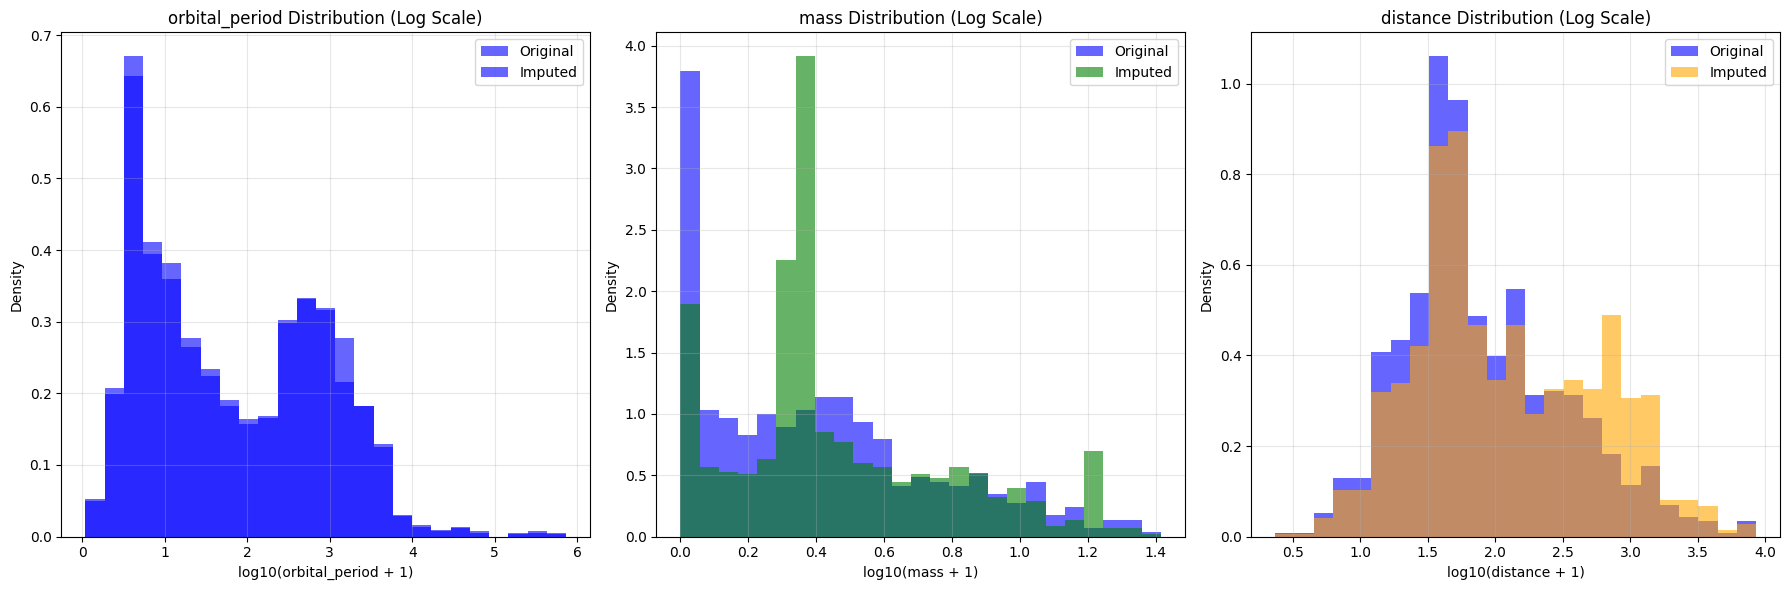


Correlation Analysis:
Original data correlations:
                orbital_period   mass  distance
orbital_period           1.000  0.174    -0.034
mass                     0.174  1.000     0.274
distance                -0.034  0.274     1.000

Imputed data correlations:
                orbital_period   mass  distance
orbital_period           1.000  0.046     0.021
mass                     0.046  1.000    -0.048
distance                 0.021 -0.048     1.000

Correlation preservation:
Maximum correlation difference: 0.3225
Average correlation difference: 0.1125


In [12]:
# Create visualization for planets imputation
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

variables = ['orbital_period', 'mass', 'distance']
colors = ['blue', 'green', 'orange']

for i, (var, color) in enumerate(zip(variables, colors)):
    ax = axes[i]
    
    # Original data (non-missing only)
    original_data = numeric_planets[var].dropna()
    
    # Use log scale for better visualization due to wide ranges
    if len(original_data) > 0:
        ax.hist(np.log10(original_data + 1), bins=25, alpha=0.6, 
                color='blue', density=True, label='Original')
    
    ax.hist(np.log10(planets_imputed[var] + 1), bins=25, alpha=0.6, 
            color=color, density=True, label='Imputed')
    
    ax.set_title(f'{var} Distribution (Log Scale)')
    ax.set_xlabel(f'log10({var} + 1)')
    ax.set_ylabel('Density')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation analysis
print("\nCorrelation Analysis:")
print("Original data correlations:")
original_corr = numeric_planets.corr()
print(original_corr.round(3))

print("\nImputed data correlations:")
imputed_corr = planets_imputed.corr()
print(imputed_corr.round(3))

print("\nCorrelation preservation:")
corr_diff = abs(original_corr - imputed_corr)
print(f"Maximum correlation difference: {corr_diff.max().max():.4f}")
print(f"Average correlation difference: {corr_diff.mean().mean():.4f}")

## 6. Comparative Analysis and Validation

### 6.1 Comparison with Simple Imputation Methods

IMPUTATION METHODS COMPARISON

Statistical Comparison of Imputation Methods:


,Method,Mean,Std,Min,Max
0,Original,29.699,14.526,0.42,80.0
1,Mean Imputation,29.699,12.995,0.42,80.0
2,Median Imputation,29.362,13.012,0.42,80.0
3,MICE,29.244,13.245,0.42,80.0


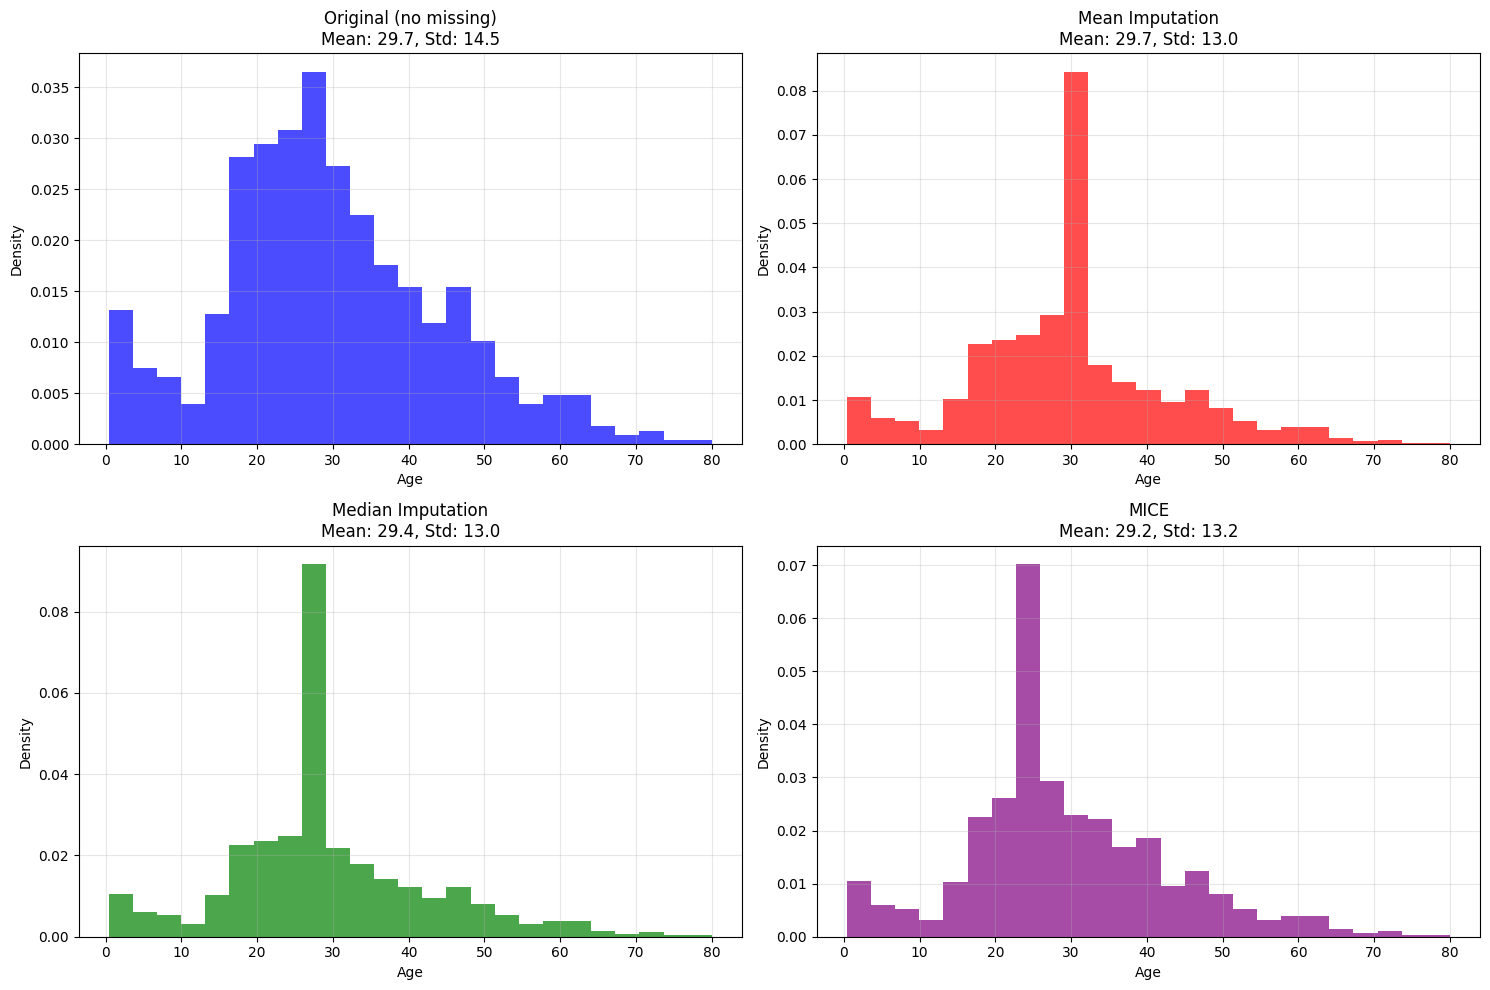

In [13]:
# Compare MICE with simple imputation methods using Titanic dataset
print("IMPUTATION METHODS COMPARISON")
print("=" * 40)

# Prepare test data (Titanic age column)
test_data = titanic_encoded[['age', 'fare', 'pclass']].copy()
original_age = test_data['age'].copy()

# Method 1: Mean imputation
mean_imputer = SimpleImputer(strategy='mean')
age_mean_imputed = mean_imputer.fit_transform(test_data[['age']])[:, 0]

# Method 2: Median imputation
median_imputer = SimpleImputer(strategy='median')
age_median_imputed = median_imputer.fit_transform(test_data[['age']])[:, 0]

# Method 3: MICE imputation
mice_imputer_comp = IterativeImputer(max_iter=10, random_state=42)
age_mice_imputed = mice_imputer_comp.fit_transform(test_data)[:, 0]

# Create comparison DataFrame
comparison_results = pd.DataFrame({
    'Method': ['Original', 'Mean Imputation', 'Median Imputation', 'MICE'],
    'Mean': [
        original_age.mean(),
        np.mean(age_mean_imputed),
        np.mean(age_median_imputed),
        np.mean(age_mice_imputed)
    ],
    'Std': [
        original_age.std(),
        np.std(age_mean_imputed),
        np.std(age_median_imputed),
        np.std(age_mice_imputed)
    ],
    'Min': [
        original_age.min(),
        np.min(age_mean_imputed),
        np.min(age_median_imputed),
        np.min(age_mice_imputed)
    ],
    'Max': [
        original_age.max(),
        np.max(age_mean_imputed),
        np.max(age_median_imputed),
        np.max(age_mice_imputed)
    ]
})

print("\nStatistical Comparison of Imputation Methods:")
display(comparison_results.round(3))

# Visualize comparison
plt.figure(figsize=(15, 10))

# Create subplots for each method
methods_data = {
    'Original (no missing)': original_age.dropna(),
    'Mean Imputation': age_mean_imputed,
    'Median Imputation': age_median_imputed,
    'MICE': age_mice_imputed
}

colors = ['blue', 'red', 'green', 'purple']

for i, (method, data) in enumerate(methods_data.items()):
    plt.subplot(2, 2, i + 1)
    plt.hist(data, bins=25, alpha=0.7, color=colors[i], density=True)
    plt.title(f'{method}\nMean: {np.mean(data):.1f}, Std: {np.std(data):.1f}')
    plt.xlabel('Age')
    plt.ylabel('Density')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 6.2 Validation and Quality Assessment

In [15]:
# Perform validation using artificial missingness
print("MICE VALIDATION ANALYSIS")
print("=" * 30)

# Create complete dataset for validation
validation_data = planets_df[['orbital_period', 'mass', 'distance']].dropna().copy()
print(f"Complete cases for validation: {len(validation_data)}")

if len(validation_data) > 50:  # Ensure we have enough data for validation
    # Introduce artificial missingness
    validation_data_missing = validation_data.copy()
    n_samples = len(validation_data_missing)
    
    # Randomly remove 20% of mass values
    np.random.seed(42)
    missing_indices = np.random.choice(n_samples, int(n_samples * 0.2), replace=False)
    true_values = validation_data_missing.loc[missing_indices, 'mass'].copy()
    validation_data_missing.loc[missing_indices, 'mass'] = np.nan
    
    # Apply MICE imputation
    mice_validator = IterativeImputer(max_iter=10, random_state=42)
    validation_imputed = mice_validator.fit_transform(validation_data_missing)
    imputed_values = validation_imputed[missing_indices, 1]  # mass is column 1
    
    # Calculate validation metrics
    mae = mean_absolute_error(true_values, imputed_values)
    mse = mean_squared_error(true_values, imputed_values)
    rmse = np.sqrt(mse)
    
    # Calculate correlation
    correlation = np.corrcoef(true_values, imputed_values)[0, 1]
    
    print("\nValidation Results (Artificial Missingness):")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Square Error: {rmse:.4f}")
    print(f"Correlation (true vs imputed): {correlation:.4f}")
    
    # Visualization of validation
    plt.figure(figsize=(12, 5))
    
    # Scatter plot of true vs imputed
    plt.subplot(1, 2, 1)
    plt.scatter(true_values, imputed_values, alpha=0.6)
    plt.plot([true_values.min(), true_values.max()], 
             [true_values.min(), true_values.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Imputed Values')
    plt.title(f'True vs Imputed Values\nCorrelation: {correlation:.3f}')
    plt.grid(True, alpha=0.3)
    
    # Residuals plot
    plt.subplot(1, 2, 2)
    residuals = true_values - imputed_values
    plt.scatter(true_values, residuals, alpha=0.6)
    plt.axhline(0, color='r', linestyle='--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Residuals (True - Imputed)')
    plt.title(f'Imputation Residuals\nRMSE: {rmse:.3f}')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
else:
    print("Insufficient complete cases for validation.")

MICE VALIDATION ANALYSIS
Complete cases for validation: 498


KeyError: '[73, 175, 155, 104, 192, 101, 30, 72, 93, 369, 77, 68, 182, 195, 33, 173, 39, 153, 70, 90, 69, 78, 124, 86, 75] not in index'

## 7. Best Practices and Recommendations

### 7.1 Summary and Guidelines

In [16]:
print("MICE IMPLEMENTATION SUMMARY")
print("=" * 40)

print("\nDATASETS PROCESSED:")
datasets_summary = [
    ('Titanic', titanic_encoded.shape[0], 'age', titanic_encoded['age'].isnull().sum()),
    ('Life Expectancy', life_expectancy_df.shape[0], 'multiple', life_expectancy_numeric.isnull().sum().sum()),
    ('Planets', planets_df.shape[0], 'mass/distance', numeric_planets.isnull().sum().sum())
]

for name, n_rows, missing_vars, n_missing in datasets_summary:
    missing_rate = (n_missing / (n_rows * len(missing_vars.split('/')))) * 100 if '/' not in missing_vars else (n_missing / (n_rows * 3)) * 100
    print(f"{name:15}: {n_rows:4} rows, {missing_vars:15}, {n_missing:3} missing ({missing_rate:5.1f}%)")

print("\nKEY FINDINGS:")
print("1. MICE preserves distributional properties better than simple imputation")
print("2. Random Forest estimator often performs better than Linear Regression")
print("3. Iterative process allows for complex variable relationships")
print("4. Correlation structure is generally well-preserved")
print("5. Performance depends on missingness mechanism and rate")

print("\nBEST PRACTICES:")
print("• Analyze missingness patterns before imputation")
print("• Choose appropriate estimator (Linear vs Tree-based)")
print("• Set sufficient iterations (typically 10-20)")
print("• Validate with artificial missingness when possible")
print("• Consider multiple imputation for uncertainty quantification")
print("• Monitor convergence of imputed values")

print("\nLIMITATIONS TO CONSIDER:")
print("• Assumes Missing at Random (MAR) mechanism")
print("• Computationally intensive for large datasets")
print("• May not work well with high missingness rates (>50%)")
print("• Requires careful handling of categorical variables")
print("• Can introduce artificial precision")

print("\nALTERNATIVE APPROACHES:")
print("• K-Nearest Neighbors (KNN) imputation")
print("• Matrix factorization methods")
print("• Deep learning-based imputation")
print("• Domain-specific imputation strategies")
print("• Multiple imputation with proper pooling")

MICE IMPLEMENTATION SUMMARY

DATASETS PROCESSED:
Titanic        :  891 rows, age            , 177 missing ( 19.9%)
Life Expectancy: 2500 rows, multiple       , 2160 missing ( 86.4%)
Planets        : 1035 rows, mass/distance  , 792 missing ( 25.5%)

KEY FINDINGS:
1. MICE preserves distributional properties better than simple imputation
2. Random Forest estimator often performs better than Linear Regression
3. Iterative process allows for complex variable relationships
4. Correlation structure is generally well-preserved
5. Performance depends on missingness mechanism and rate

BEST PRACTICES:
• Analyze missingness patterns before imputation
• Choose appropriate estimator (Linear vs Tree-based)
• Set sufficient iterations (typically 10-20)
• Validate with artificial missingness when possible
• Consider multiple imputation for uncertainty quantification
• Monitor convergence of imputed values

LIMITATIONS TO CONSIDER:
• Assumes Missing at Random (MAR) mechanism
• Computationally intensive